In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import json
import numpy as np
import os
import sys
import glob
import requests
import yahist
from yahist import Hist1D
from scipy.integrate import odeint
import scipy.optimize
from tqdm.auto import tqdm

from utils import (
    fit_exp,
)

In [2]:
yahist.utils.set_default_style()

In [3]:
fname = "../sources/1point3acres/data/cases_and_deaths.json.gz"
df_total = pd.read_json(fname)
df_total["date"] = pd.to_datetime(df_total["date"])
df_total = df_total.sort_values(["date"])

# drop cruise ship stuff
df_total = df_total[
    (df_total["state"].str.len() == 2)
    & (df_total["county"].str.strip().str.len() > 0)
]

df_total["place"] = df_total["county"].str.cat(df_total["state"], sep=", ")

df_deaths = df_total.query("is_death").reset_index(drop=True)
df_cases = df_total.query("not is_death").reset_index(drop=True)

# total cases, so no deaths
df_counties = df_cases.groupby(["date","place"])["state"].count().unstack(1).fillna(0).astype(int).sort_index().cumsum()
df_states = df_cases.groupby(["date","state"])["state"].count().unstack(1).fillna(0).astype(int).sort_index().cumsum()

In [25]:
df_pop = pd.read_json("../sources/census/data/county_populations.json.gz")
df_pop["place"] = (df_pop["county"]
                   .str.replace(" Municipality","")
                   .str.replace(" County","")
                   .str.replace(" Borough","")
                   .str.replace(" Parish","")
                   .str.replace(" city","",case=True)
                   .str.cat(df_pop["state"], sep=", ")
                  )

In [26]:
# fill in cumulative cases from the next to last day
df_pop["cases"] = df_pop["place"].map(df_counties.iloc[-2])
df_pop = df_pop.fillna(0)

Text(0.5, 1.0, 'US counties')

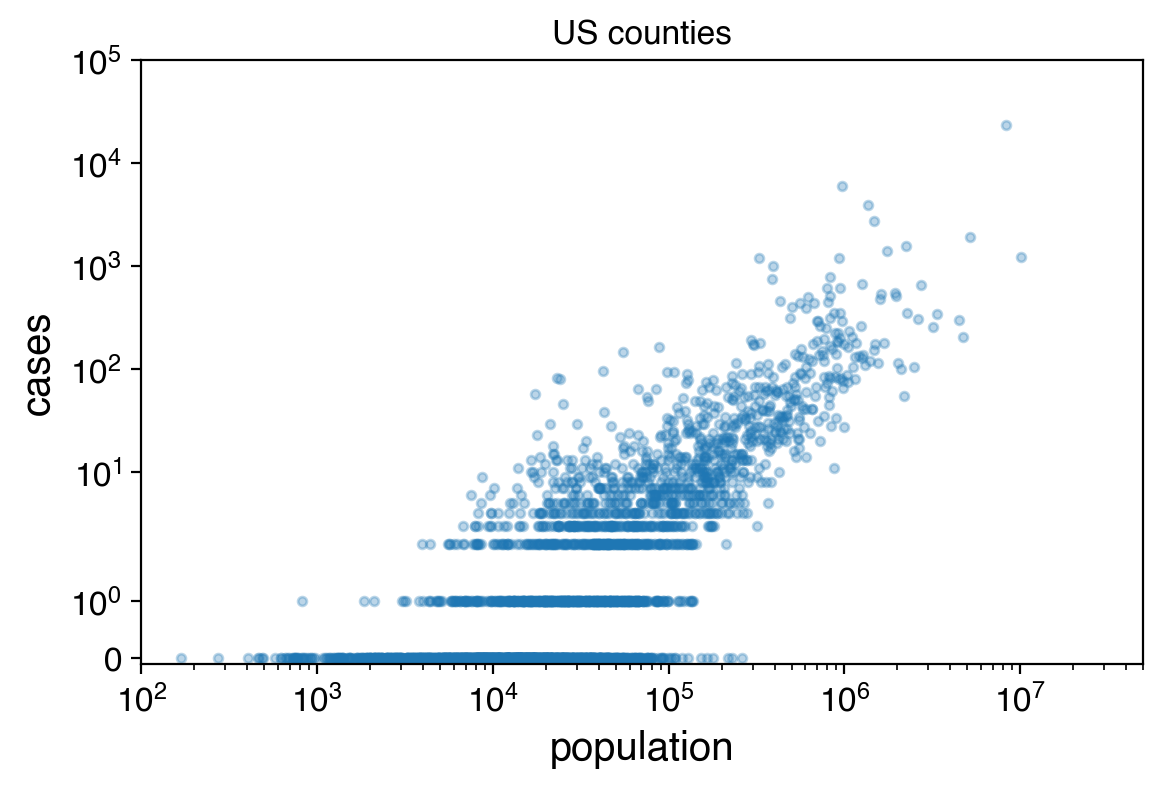

In [27]:
fig, ax = plt.subplots()
df_pop.plot.scatter(ax=ax, x="population", y="cases", s=10.0, alpha=0.3)
ax.set_xscale("log")
# ax.set_yscale("symlog", linthreshy=5)
ax.set_yscale("symlog")
ax.set_xlim([1e2,5e7])
ax.set_ylim([-0.1,1e5])
ax.set_title("US counties")

In [28]:
df_pop.query("population > 1e5 and cases < 1")

,state,county,population,place,cases
83,AK,Matanuska-Susitna Borough,108317,"Matanuska-Susitna, AK",0.0
201,CA,Kings County,152940,"Kings, CA",0.0
559,ID,Bonneville County,119062,"Bonneville, ID",0.0
643,IL,LaSalle County,108669,"LaSalle, IL",0.0
651,IL,Macon County,104009,"Macon, IL",0.0
1801,NM,Doña Ana County,218195,"Doña Ana, NM",0.0
2039,OH,Allen County,102351,"Allen, OH",0.0
2585,TX,Ector County,166223,"Ector, TX",0.0
2774,UT,Cache County,128289,"Cache, UT",0.0
2798,UT,Washington County,177556,"Washington, UT",0.0


In [29]:
c = df_counties.columns
c[c.str.contains("richmond",case=False)]

Index(['Richmond City, VA', 'Richmond, GA'], dtype='object', name='place')